# Adversarial Search: Playing Dots and Boxes


## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play the game Dots and Boxes:

> "Dots and Boxes is a pencil-and-paper game for two players. The game starts with an empty grid of dots. Usually two players take turns adding a single horizontal or vertical line between two unjoined adjacent dots. A player who completes the fourth side of a 1x1 box earns one point and takes another turn. A point is typically recorded by placing a mark that identifies the player in the box, such as an initial. The game ends when no more lines can be placed. The winner is the player with the most points. The board may be of any size grid." (see [Dots and Boxes on Wikipedia](https://en.wikipedia.org/wiki/Dots_and_Boxes))

You can play Dots and Boxes [here](https://www.math.ucla.edu/~tom/Games/dots&boxes.html).

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

### Answer:
* Initial state: Empty board containing an 2D array of dots of size $m*n$. No lines are connected and no boxes are formed. It is player Max's turn.
* Actions: Place one line on available edge between two dots 
* Transition model: f(prev_state): action x prev_state = {all instances of prev_state with one additional line placed on a previously available edge (and potentially an additional box filled)} Swap turns IFF no new box was formed.
* Test for the terminal state: Either Player Max or Player Min has formed more than $\lfloor\frac{(m-1)(n-1)}{2}\rfloor+1$ boxes OR every possible horizontal and vertical line position has been occupied.
* Utility for terminal states: Player Max has more boxes filled in than Player min, OR Player Max has formed more than $\frac{n}{2}+1$ boxes.

How big is the state space? Give an estimate and explain it.

### Answer **(FINISH!!!!!!!!!):** 
State Space Estimation: # possible line configurations * # possible initial configurations.

**possible line configurations for board size n x n:**
(|{empty, your line, opponent line}| ^ ((n-1)(n))*2) -- Horizontal and vertical (2) orientatations -- each orientation has n "rows", with n-1 lines available to be placed per row. Order of the lines matters, so we perform a permutation calculation.

e.g. for board size 5 x 5: # line configurations would be 3^40.

**possible initialed configurations for board size n x n:** 
(|{no initial, your initial, opponent initial}| ^ (n^2 - n)) -- At minimum, n boxes MUST be empty, so we exclude them from the possible state calculation. Then the remaining n^2 - n boxes can initialed by a player or not. Order of the initials matter, so we perform a permutation calculation.

Full estimation: 3^(((n-1)(n))*2) * 3^(n^2-n). The line estimation is an accurate permutation. However, for initials, there is only one scenario in which the number of initials is 9 (that is, initials filled by each layer along the diagonal). While this is a valid state, our agent will never try to achieve this strategy, so it's likely in practice that we will have to worry with far fewer states (say, only 6 or 7 initialized boxes).

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [316]:
# Your code/ answer goes here.

## Task 2: Game Environment and Random Agent [30 point]

You need to think about a data structure to represent the board meaning he placed lines and who finished what box. There are many options. Let's represent the board using a simple dictionary where `n` and `m` represents the number of dots horizontaly and vertically, respectively. Everybody needs to use the same representation so we can let agents play against each other later. 

In [317]:
import numpy as np

def empty_board(m = 4,n = 4):
    return {
    'n': n,  ### hoizontal dots
    'm': m   ### vertical dots
    }

board = {
    'n': 4,  ### hoizontal dots
    'm': 4   ### vertical dots
}

def draw_line(board, orientation, row, col):
    """
    Place a line on an exiting board.
       
    Parameters
    ----------
    board: dict
        the board
    orientation: str
        either 'h' or 'v' for horizontal or vertical
    row, col: int
        index of the starting dot for the line (starting with 0)
    
    """
    
    if orientation not in ['h', 'v']:
        return False
        
    if row < 0 or col < 0:
        return False
        
    if row >= board['n'] + (orientation == 'v') or col >= board['m'] + (orientation == 'h'):
        return False
        
    if (orientation, row, col) in board:
        return False
            
    board[(orientation, row, col)] = True
    return True
    

print(draw_line(board, "h", 1, 1))
print(draw_line(board, "v", 1, 1))

# this hould not work
print(draw_line(board, "h", 1, 1))

board

True
True
False


{'n': 4, 'm': 4, ('h', 1, 1): True, ('v', 1, 1): True}

Write code to display the board. **Bonus point: Post your visualization code with an example output to the discussion board. The best visualization will earn you bonus participation points in this class.**

In [318]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def show_board(board, show_results=False):
    n = board['n']  # Rows
    m = board['m']  # Columns
   
    fig, ax = plt.subplots()
    ax.set_xlim(-0.5, m-0.5)
    ax.set_ylim(-0.5, n-0.5)
   
    # Draw dots
    for row in range(n):
        for col in range(m):
            if (row, col) in board:
                ax.scatter(row, col, s=100, marker='o', color='black')
            else:
                ax.scatter(row, col, s=100, marker='o', color='black')
     
    # Draw lines
    for line in board:
        # print(line)
        if line != 'n' and line != 'm' and line != -1 and line != 1:
            # print(line)
            if len(line) > 2:
                # Draw Horizontal line
                if line[0] == 'h':
                    #print("for line ('h'",line[1],line[2],"), plot line from X=",line[2]+1,"to",line[2]+2,"and Y=",n-line[1],"to",n-line[1])
                    #l = mlines.Line2D([line[2]+1,line[2]+2], [n-line[1],n-line[1]], color='black')
                    l = mlines.Line2D([line[2],line[2]+1], [n-line[1]-1,n-line[1]-1], color='black')
                    ax.add_line(l)
                # Draw Vertical line
                elif line[0] == 'v':
                    #print("for line ('v'",line[1],line[2],"), plot line from X=",line[2]+1,"to",line[2]+1,"and Y=",n-line[1],"to",n-line[1]-1)                    
                    #l = mlines.Line2D([line[2]+1,line[2]+1], [n-line[1],n-line[1]-1], color='black')
                    l = mlines.Line2D([line[2],line[2]], [n-line[1]-2,n-line[1]-1], color='black')
                    ax.add_line(l)
   
    # Check for boxes
    # Boxes are stored in board with (row, col) as key and player (1 or -1) as value
    # eg: board[(3, 1)] = 1 -> player 1 has a box with top left vertex at (3, 1)
    for box in board:
        if box != 'n' and box != 'm' and box != -1 and box != 1:
            if len(box) == 2:
                if board[(box[0], box[1])] == 1:
                    ax.add_patch(plt.Rectangle((box[1], n - box[0] - 1), 1, -1, color='b'))
                    #print("blue box at point (",box[1],",",n - box[0] - 1,")")
                else:
                    ax.add_patch(plt.Rectangle((box[1], n - box[0] - 1), 1, -1, color='r'))
                    #print("red box at point (",box[1],",",n - box[0] - 1,")")
   
    # Print results  
    if (show_results):
        print('Results:')
        print('         -1:', board[-1])
        print('          1:', board[1])
   
    # Set up plot to start at (1, 1)
    x = []
    y = []
    for row in range(board['n']):
        # x.append(row)
        x.append(row+1)
    for col in range(board['m']):
        # y.append(col)
        y.append(col+1)
    default_x_ticks = range(len(x))
    plt.xticks(default_x_ticks, x)
    default_y_ticks = range(len(y))
    plt.yticks(default_y_ticks, y)
   
    plt.show()

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

__Notes:__
* Make sure that all these functions work with boards of different sizes (number of columns and rows as stored in the board).
* The result function evaluates if the player closed a box and needs to store that information on the board. Add elements of the form `(row,col): player` to the board dictionary. `row` and `col` are the coordinates for the box and `player` is +1 or -1 representing the player. For example `(0,0): -1` means that the top-left box belongs to the other player. 

In [319]:
# Helper function to return all the boxes in a board owned by a player.
def get_boxes(board):

    boxes = []
    for key in board.keys():
        if (isinstance(key,tuple) and len(key) == 2):
            boxes.append(key)

    return boxes

# Helper function to return all the lines in the board.
def get_lines(board):
    lines = []
    for key in board.keys():
        if (isinstance(key,tuple) and len(key) == 3):
            lines.append(key)

    return lines

In [320]:
# Referencing this paper as I go:
# https://www.aaai.org/ocs/index.php/AAAI/AAAI12/paper/viewFile/5126/5218#:~:text=Dots%2DAnd%2DBoxes%20is%20impartial,pieces%20of%20a%20certain%20color.

def result(board,orientation,row,col,player):
    """
    Evaluates the state of the board, detecting and filling any unfilled boxes.
    Only searches for unfilled boxes based on the most recent line placed 
    (determined by params orientation, row, and col).
       
    Parameters
    ----------
    board: dict
        the board
    orientation: str
        either 'h' or 'v' for horizontal or vertical
    row, col: int
        index of the starting dot for the line (starting with 0)
    player
        whether player max (1) or player min (-1) placed the line
    
    """

    # Place the line.
    board[(orientation,row,col)] = True

    # Check if boxes are formed, and place them.
    if (orientation == 'h'):
        # Horizontal case -- check if a box formed above (if possible)
        if (row > 0):
            if (('h',row-1,col) in board and 
                ('v',row-1,col) in board and
                ('v',row-1,col+1) in board ):
                
                #print("new box added above -- (",row-1,",",col,")")
                board[(row-1,col)] = player
        # Horizontal case -- check if a box formed below (if possible)
        if (row < board['n'] - 1):
            if (('h',row+1,col) in board and 
            ('v',row,col) in board and
            ('v',row,col+1) in board):

                #print("new box added below -- (",row,",",col,")")          
                board[(row,col)] = player

    elif (orientation == 'v'):
        # Vertical case -- check if a box formed to the left (if possible)
        if (col > 0):
            if (('v',row,col-1) in board and 
            ('h',row,col-1) in board and
            ('h',row+1,col-1) in board):
                
                #print("new box added left -- (",row,",",col-1,")")   
                board[(row,col-1)] = player

        # Vertical case -- check if a box formed to the right (if possible)
        if (row < board['m'] - 1):
            if (('v',row,col+1) in board and 
            ('h',row,col) in board and
            ('h',row+1,col) in board):

                #print("new box added right -- (",row,",",col,")")                  
                board[(row,col)] = player

    #print("BOARD UPDATED")
    #show_board(board)

    return board

In [321]:
# Utility: Ratio of boxes Max owns to boxes Min owns.
def utility(board):

    utility = 0

    # Who owns what box?
    # Calculate utility by calculating Max - Min.
    for box in get_boxes(board):
        if (board[box] == 1):
            utility += 1
        elif (board[box] == -1):
            utility -= 1

    # TODO: WE WANT TO ADD SOME REGULARIZATION TO THIS FUNCTION.

    return utility

In [322]:
def check_win(board):
    """
    Helper function to check whether a player has placed enough boxes to guarantee a win 
    (i.e. guarantee ownership of more boxes than the other)
    """
    boxes = get_boxes(board)

    win_threshold = (board['m']-1)*(board['n']-1)//2 + 1

    # At any point, if it's determined that max or min has obtained 'win_threshold' boxes
    # Then return that player as the winner.
    # Otherwise, return 0 (No winner yet).
    min_cnt = 0
    max_cnt = 0
    for box in boxes:
        if board[box] == 1:
            max_cnt += 1
        elif board[box] == -1:
            min_cnt += 1
        
        if max_cnt >= win_threshold:
            return 1
        if min_cnt >= win_threshold:
            return -1


    return 0
    
def check_board_full(board):
    """
    Helper function to check whether the board is completely filled with
    lines (i.e. whether there are no more possible moves to make).
    """

    m = board['m']
    n = board['n']
    
    return len(get_lines(board)) >= m*(n-1) + n*(m-1)

def terminal(board):
    """
    Terminal function -- checks whether a given board state is a terminal
    node.
    """
    return check_win(board) or check_board_full(board)

In [323]:
def actions(board):
    """
    Actions function -- returns positions of all possible lines the player can place.
    """
    res = []
    for i in range(board['n']):
        for j in range(board['m']):
            if (i == board['n']-1 and j == board['m']-1):
                continue
            if (('h',i,j) not in board and j != board['m']-1):
                res.append(('h',i,j))
            if (('v',i,j) not in board and i != board['n']-1):
                res.append(('v',i,j))

    return res

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on by the environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [324]:
# Your code/ answer goes here.
def random_player(board, player=None):
    possible_actions = actions(board)
    return possible_actions[np.random.choice(len(possible_actions),1)[0]]

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [329]:
def switch_player(player, pfun1, pfun2):
    if player == 1:
        return -1, pfun2
    elif player == -1:
        return 1, pfun1

# Your code/ answer goes here.
def play(pfun1, pfun2, N = 1, show_final_board = False):
    """Let two agents play each other N times. red starts. red and yellow are agent functions that 
    get the board as the percept and return their next action.
    
    Code Adopted and modified from tictactoe_interactive.ipynb.
    """
    results = {1: 0, -1: 0, 0: 0}
    
    for i in range(N):
        board = empty_board()
        player, fun = 1, pfun1
        
        while True:
            action = fun(board, player)
            board = result(board, action[0], action[1], action[2], player)
            win = check_win(board)   # returns the 'n' if the game is not done.
            if win != 0:
                results[win] += 1
                if show_final_board: 
                    print("Final board:")
                    show_board(board)
                break

            if check_board_full(board):
                results[0] += 1
                break
            
            player, fun = switch_player(player, pfun1, pfun2)   
    
    return results

Final board:


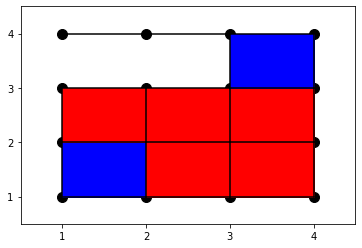

Final board:


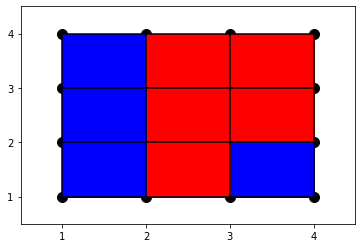

Final board:


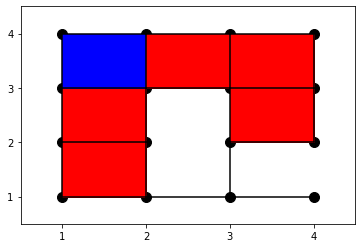

Final board:


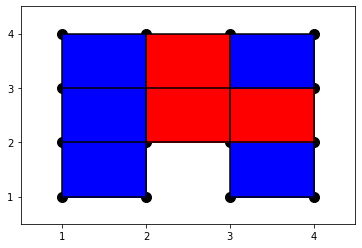

Final board:


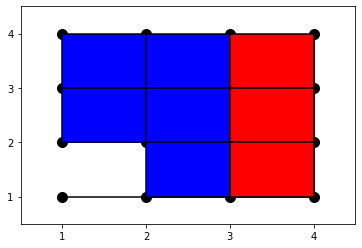

In [332]:
# Demo of the two random players playing. Final board printed for 5 games.
results = play(random_player, random_player, N=5, show_final_board=True)

In [339]:
# Run the game 1000 times and display the results.
results = play(random_player, random_player, N=1000, show_final_board=False)
print("Blue (1):",results[1])
print("Red (-1):",results[-1])
print("Draws (0):",results[0])

Blue (1): 347
Red (-1): 653
Draws (0): 0


## Task 3: Minimax Search with Alpha-Beta Pruning [30 points]

### Implement the search starting.

Implement the search starting from a given board and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for larger board may be too large. You can experiment with smaller boards.

In [312]:
# Your code/ answer goes here.

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [10]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board make the board larger. What is the largest board you can solve?

In [11]:
# Your code/ answer goes here.

### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [12]:
# Your code/ answer goes here.

### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

In [13]:
# Your code/ answer goes here.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [14]:
# Your code/ answer goes here.

## Task 4: Heuristic Alpha-Beta Tree Search [30 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [15]:
# Your code/ answer goes here.

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [16]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

In [17]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [18]:
# Your code/ answer goes here.

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [19]:
# Your code/ answer goes here.

## Tournament task [+1 to 5% bonus on your course grade; will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above. 

In [20]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move for a standard board ($5 \times 5$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [21]:
# Your code/ answer goes here.